The columns from left to right are name, hr, sigma_hr, T90 (or T50), sigma_T90

I suggest you work with T90.

Also note that if you have upgraded your sklearn, you will need to upgrade your codes to 

as GMM is now GaussianMixtureModels etc.

You can do two tests

1) without any outlier rejection

2) rejecting datapoints with large errors (with  rejecting values with error/value > 30% 

you can also try using Extreme Deconvolution (which accounts for errors while using GMM)

In [1]:
# import pandas as pd
import numpy as np
import math
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
#from astroML.plotting.tools import draw_ellipse
import itertools
from scipy import linalg
import matplotlib as mpl
from matplotlib.colors import LogNorm
from sklearn import mixture
from xdgmm import XDGMM
# from astroML.density_estimation import XDGMM

In [2]:
arr = np.genfromtxt("hrdata_10yr_T90_Final_w_err copy.txt", dtype=float,delimiter = "\t")
print(arr[503])

[        nan -0.05794558  0.40968589  0.064       0.0715542 ]


In [3]:
t90=[]
hr=[]
dt90=[]
dhr=[]
COLUMN_T90_ERROR = 4
COLUMN_T90 = 3
COLUMN_HR_ERROR = 2
COLUMN_HR = 1
for i in range(len(arr)):
    if arr[i][1] > 0 and arr[i][3] > 0:
        t90.append(math.log(arr[i][3]))
        hr.append(math.log(arr[i][1]))
        dhr.append(arr[i][2] / arr[i][1])
        dt90.append((arr[i][4]/arr[i][3]))
    else:
        print("Error for this GRB {} at index {} is more than 0.3".format(arr[i], i))
print(len(dt90))

Error for this GRB [        nan -0.05794558  0.40968589  0.064       0.0715542 ] at index 503 is more than 0.3
2329


In [4]:
# stack the data 
X = np.vstack([t90, hr]).T
X = X[~np.isnan(X).any(axis=1)]
X = X[np.isfinite(X).any(axis=1)]

#change list to matrix
mat_dt90 = np.zeros(len(dt90))
mat_dhr = np.zeros(len(dhr))
for i in range(len(dhr)):
    mat_dt90[i] = dt90[i]
    mat_dhr[i] = dhr[i]

# stack data error
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([mat_dt90**2, mat_dhr**2]).T

In [5]:
# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.arange(1,6)
xdgmm = XDGMM()

In [6]:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X, Xerr, param_range)
aic, optimal_n_comp, lowest_aic = xdgmm.aic_test(X, Xerr, param_range)

N = 1 , BIC = 13406.952679253236
N = 2 , BIC = 13036.84240625882
N = 3 , BIC = 13039.040379803626
N = 4 , BIC = 13084.890612940158
N = 5 , BIC = 13116.508127179084
N = 1 , AIC = 13378.186707903815  , means =  [[ 2.78924565 -0.34608799]]  , covars =  [[[ 2.32195192 -0.32696221]
  [-0.32696221  0.33705603]]]  , weights =  [1.]
N = 2 , AIC = 12973.556870551967  , means =  [[ 3.2747138  -0.45555153]
 [-0.09090505  0.34018063]]  , covars =  [[[ 1.10577029 -0.04360887]
  [-0.04360887  0.27912473]]

 [[ 0.97495835 -0.19533093]
  [-0.19533093  0.23587717]]]  , weights =  [0.84537509 0.15462491]
N = 3 , AIC = 12941.236371071303  , means =  [[-0.41296188  0.4319021 ]
 [ 3.70926858 -0.4574521 ]
 [ 2.58876556 -0.40840336]]  , covars =  [[[ 0.65283279 -0.17677091]
  [-0.17677091  0.17717661]]

 [[ 0.7558753  -0.0375553 ]
  [-0.0375553   0.18871536]]

 [[ 1.27593653 -0.11251407]
  [-0.11251407  0.40638448]]]  , weights =  [0.11721665 0.45999029 0.42279306]
N = 4 , AIC = 12952.599757722364  , means =

In [7]:
print("AIC2 {} and AIC3 {} , Aic diff : {}".format(aic[1], aic[2], aic[1]-aic[2]))
print("BIC2 {} and BIC3 {} , Bic diff : {}".format(bic[1], bic[2], bic[1]-bic[2]))
print(optimal_n_comp)

AIC2 12973.556870551967 and AIC3 12941.236371071303 , Aic diff : 32.320499480663784
BIC2 13036.84240625882 and BIC3 13039.040379803626 , Bic diff : -2.197973544805791
3


https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html

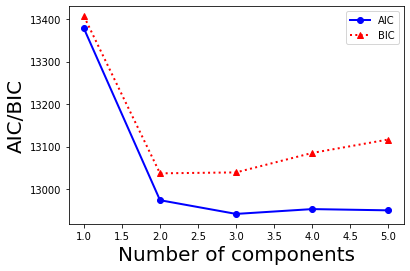

In [8]:
plt.plot(param_range, aic, '-k', label='AIC',color ='blue', marker='o',lw=2)
plt.plot(param_range, bic, ':k', label='BIC', color = 'red', marker='^',lw=2)
plt.legend(loc=1)
plt.xlabel('Number of components',size=20 )
plt.ylabel('AIC/BIC', size=20)
plt.show()